# Spotify Classification-based Recommendation System
### Spotify API Data Engineering + Machine Learning Project
Prepared by: [Alif Naufal](https://github.com/alif898)

Last updated: 6 May 2022
### Introduction
As an avid-user of spotify and a big fan of music in general, I have always been curious about 2 things:
1. What makes certain songs popular? Is there a way to quantify and even predict what makes songs popular?
2. How does the Spotify recommendation algorithm work? Under the 'Made for You' section, there are a multitude of curated playlists based on genres, artists and even moods. I have managed to discover a plethora of artists and songs through these playlists that I would not have known about otherwise, yet it can sometimes feel very hit-or-miss.

I then realised that Spotify has an API that allows us to fetch information about tracks, artists, playlists and I thought it would be interesting to answer the above 2 questions.

Given the vast amount of songs on Spotify, we want to be able to handle large amounts of data. Therefore, I decided to use this as an opportunity to learn and use Apache Spark, through PySpark. This project will be done on Databricks. The data will also be stored on Databricks itself, through its data lake, Delta Lake. The machine learning models used will be from the pyspark.ml package, which works with PySpark dataframes, which should be faster and more scalable with big data, as compared to the usual pandas -> scikit learn workflow.

This project will be split into the following parts:
1. Methodology
2. Data Engineering - ETL Pipeline to fetch data from Spotify API into Delta Lake
3. EDA
4. Regression model to predict track popularity
5. Classification model to recommend songs
6. Conclusion

### 1. Methodology

From the Spotify API, we are able to fetch a wide variety of information about a track. Besides information such as artist name, genre, there is a particular interesting category of variables known as audio features. More details [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features).

Essentially, these audio features capture characteristics of tracks that might seemingly be difficult to quantify. For example, the 'energy' variable, which goes from 0-1, represents the intensity and energy that a track has. According to Spotify, energetic tracks feel fast, loud and noisy. Unfortunately, technical details of how such variables are actually calculated are not revealed (It is unlikely that Spotify measures this manually). Nevertheless, by being able to quantify seemingly abstract characteristics of tracks, we can take advantage of these features to build our models.

To tackle the first question, I will approach it as a regression problem, whereby the variable to predict is 'track_pop', which measures the popularity of a track from 0-100. We will then use the audio features to try and predict this variable. I suspect certain features such as danceability & energy will be the main contributors towards track popularity.

For this, I will be trying the following models:
 - Linear Regression
 - Decision Tree Regression
 - Random Forest Regression
 - Gradient Boosted Trees Regression

For the second question, I decided to tackle this from the perspective of a classification problem instead of a typical recommendation system problem. This is mainly because it is easier to frame the issue of how much I like a song as a binary choice, either I like the song or I don't. This information can easily be gathered through the songs I save in my playlists. If I had to use a scale-based rating system, I would have to manually rate songs and this will be time consuming.

As such, the idea here is that the recommendation system will take in playlists of tracks that I already like, as well as a pool of tracks to source recommendations from. Based on the characteristics of the tracks I like, it will study these features and attempt to select tracks from the pool of other tracks to recommend. Artists and genres of songs will not be used as features. Personally, I wanted to explore recommendations without a bias towards recommending tracks from the same artists and genres. Furthermore, a single track has multiple genres and it is difficult to construct relationships between similar genres, e.g. Spotify has genres such as artpop and dreampop, which are somewhat related, but I do not have access to an exhaustive list of such relations.

For this, I will be trying the following models:
 - Logistic Regression
 - Decision Tree Classifier
 - Random Forest Classifier
 - Gradient Boosted Trees Classifier
 
 I will also be using MLflow, to log the models. This allows for an easy comparison of model performance, as Databricks has native integreations with MLflow.

### 2. Data Engineering

Before even starting to analyse the data or run our ML models, we first need to set up our data pipeline. As mentioned earlier, I will be using PySpark via Databricks. We also need to establish our connection to the Spotify API, which will be done via [spotipy](https://spotipy.readthedocs.io/), a package that provides a convenient interface for Spotify API with python.

Take note you need to input your Spotify API login details, which is available through a Spotify Developer account, available [here](https://developer.spotify.com/).

In [0]:
# Installing required packages
%pip install mlflow
%pip install spotipy

Python interpreter will be restarted.
  Created wheel for databricks-cli: filename=databricks_cli-0.17.0-py3-none-any.whl size=141932 sha256=d5017cf0dfa375e6f04d4dcaf9445b41585301ca62b490e4e21be3970c406153
  Stored in directory: /root/.cache/pip/wheels/bc/ef/2a/18885b70c6b78d4b9612ef2bf4bfdc7325f43db9d817d20f3f
Successfully built databricks-cli
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f4ccad93-de94-44e3-9f0e-0f397281f8bc
    Can't uninstall 'Jinja2'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Not uninstalling urllib3 at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f4ccad93-de94-44e3-9f0e-0f3972

In [0]:
# Importing required packages
from __future__ import annotations
import random
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# General spark & EDA related utilities
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# Regression models
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Classification models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# MLFlow
import mlflow
import mlflow.spark

# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Here we initiliase our SparkSession, set our save location at Delta Lake and set our Spotify API login details.

In [0]:
# Initialising SparkSession
# mlflow-spark JAR attached
spark = SparkSession.builder.appName('Spotify Project').config("spark.jars.packages", "org.mlflow.mlflow-spark").getOrCreate()

# Initialising table
save_path = '/tmp/delta/tracks'
spark.sql("create table if not exists tracks using delta location '" + save_path + "'")

# Spotify API Login Details
client_id = 'XXX'
client_secret = 'XXX'

# Initialising connection to Spotify API
client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, 
    client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

We then need to define the schema for our database. Although PySpark can infer the schema when creating a DataFrame, it is always better to define the schema, which will guarantee that the fields will be of the correct type. We are also able to enforce that fields cannot be null.

In [0]:
# Defining schema, all fields do not allow null values
schema = StructType([
    StructField('is_favourite', IntegerType(), False),
    StructField('track_uri', StringType(), False),
    StructField('track_name', StringType(), False),
    StructField('track_pop', IntegerType(), False),
    StructField('artist_name', StringType(), False),
    StructField('artist_pop', IntegerType(), False),
    StructField('artist_genre', ArrayType(StringType(), False), False),
    StructField('album_name', StringType(), False),
    StructField('acousticness', FloatType(), False),
    StructField('danceability', FloatType(), False),
    StructField('duration_ms', IntegerType(), False),
    StructField('energy', FloatType(), False),
    StructField('instrumentalness', FloatType(), False),
    StructField('key', IntegerType(), False),
    StructField('liveness', FloatType(), False),
    StructField('loudness', FloatType(), False),
    StructField('mode', IntegerType(), False),
    StructField('speechiness', FloatType(), False),
    StructField('tempo', FloatType(), False),
    StructField('valence', FloatType(), False)
])

Now we will define some functions that will handle the Transform & Load portions of our ETL pipeline.

Note, Spotify URI (Uniform Resource Indicator) basically refers to the 'id' of a track, album, playlist or artist profile on Spotify.

In [0]:
def link_to_uri(link: str) -> str:
    """
    Helper function that fetches the URI from a playlist link
    
    * link: Playlist link
    """
    return link.split('/')[-1].split('?')[0]



def uri_to_df(uri: str, is_favourite: bool) -> pyspark.sql.DataFrame:
    """
    Function that takes in playlist URI and creates a DataFrame containing details of its songs
    
    * uri: Playlist URI
    * is_favourite: Whether or not to mark tracks as favourited
    """
    
    # Extracting columns from schema
    columns = schema.fieldNames()
    # Initialising dictionary containing list for each column
    values = {key: [] for key in columns}
    
    # Iterating through the tracks, we store the values in the relevant list for each column
    for track in sp.playlist_tracks(uri)['items']:
        try:
            next_track_uri = track['track']['uri']
            if 'local' in next_track_uri or next_track_uri is None:
                # Spotify API does not work well with tracks loaded from local files, naturally some fields will be empty/null
                continue
            values['is_favourite'].append(1 if is_favourite else 0)
            values['track_uri'].append(next_track_uri)
            track_name = track['track']['name']
            values['track_name'].append(track_name)
            values['track_pop'].append(track['track']['popularity'])

            next_artist_uri = track['track']['artists'][0]['uri']
            next_artist_info = sp.artist(next_artist_uri)
            
            artist_name = track['track']['artists'][0]['name']
            values['artist_name'].append(artist_name)
            values['artist_pop'].append(next_artist_info['popularity'])
            values['artist_genre'].append(next_artist_info['genres'])
            values['album_name'].append(track['track']['album']['name'])
            
            # Audio features can be processed in a replicable & predictable way, thus we can use a loop, unlike other columns
            next_audio_feature = sp.audio_features(next_track_uri)[0]
            schema_dict = schema.jsonValue()['fields']
            for i in range(columns.index('acousticness'), len(columns)):
                feature = columns[i]
                if schema_dict[i]['type'] == 'float':
                    values[feature].append(float(next_audio_feature[feature]))
                else:
                    values[feature].append(int(next_audio_feature[feature]))
            
        except (TypeError, ValueError) as e:
            # Ignore tracks that can't be read and print the corresponding error to aid in debugging
            print(f"Error in processing: {next_track_uri}: {track_name} by {artist_name}: {e}")
            
    zipped = list(zip(*values.values()))
    df = spark.createDataFrame(data=zipped, schema=schema)
    return df



def load_into_table(links: list, is_favourite: bool) -> None:
    """
    Helper function that applies uri_to_df to a list of playlist links and loads them into the 'tracks' table
    
    * links: List containg the links of playlist to load
    * is_favourite: Whether or not to mark tracks as favourited
    """
    for link in links:
        df = uri_to_df(link_to_uri(link), is_favourite)
        df.write.format('delta').mode('append').save(save_path)

Here is the code that can clear the current tracks stored if we wish to do so.

In [0]:
# If we wish to clear the current tracks stored
dbutils.fs.rm(save_path, recurse=True)

Out[5]: True

Here is where we start extracting the data from Spotify.

build_links is where you put the links of playlists containing tracks to build recommendations from.

source_links is where you put the links of playlists contianing tracks to source recommendations from.

Note that playlists must be public. For the regression problem, either build_links or source_links is fine as whether the tracks are marked as favourited is not used in the models.

Alternatively, we can fetch the playlists built by Spotify to source recommendations from. The official Spotify account has a wide variety of playlists that we can use. They are regularly updated with new songs and are well-known and followed, providing us with a solid pool of tracks to recommend. Both random and non-random fetching of playlists are available for use.

In [0]:
# Links to build recommendations from
build_links = [
    'https://open.spotify.com/playlist/4hOOmIRVQUbSTXJ6lCuQev?si=cc0538831bc740a8', 
    'https://open.spotify.com/playlist/5yLZWcOdObgYaxuwUW1BPO?si=c58e1fc211e145f5',
    'https://open.spotify.com/playlist/1432rWv57LQzYQ7ZIp0Cch?si=0d739e85cbba4a8b',
    'https://open.spotify.com/playlist/1Oy2N0n5WJyTinFVrBhxKl?si=5346ba445b564dca',
    'https://open.spotify.com/playlist/1462EzgAbNp47xtzxGmRs6?si=82ff7a3ebf954285',
    'https://open.spotify.com/playlist/5wrXSkyvwG4ZMNsjCY7lwl?si=4fb0162e47864bd7',
    'https://open.spotify.com/playlist/3pauHNVud33Rz6uCNao7aD?si=696af6bdda2e4a1f',
    'https://open.spotify.com/playlist/2JpyHTN2ZEmDMR4AbGE3pZ?si=e9b12505c18d4f0b',
    'https://open.spotify.com/playlist/3tFBBMcYbGCQ5DgMJWKWdp?si=8143b10b61304d34',
    'https://open.spotify.com/playlist/2prg24g0hK7r11bDatm66m?si=1378314233d94382',
    'https://open.spotify.com/playlist/6rMMJQ4szZAqz3oq4vNvEK?si=897564cce0fb4944',
    'https://open.spotify.com/playlist/5u55v0uhg69cx1g5IC9u9V?si=fc8fcb0631a143fb',
]
load_into_table(build_links, True)

# Links to source recommendations from
source_links = [
    
]
load_into_table(source_links, False)

# If we wish to use Spotify playlists to source recommendations
def fetch_spotify_playlists(n: int, randomise: bool, seed: int=1) -> list:
    """
    Function that fetches n playlists and loads them into the 'tracks' table. Able to randomise playlists fetched
    
    * n: Number of playlists to fetch. Note that each playlist contains 50 songs
    * randomise: Whether or not to fetch a random set of playlist or just sequentially as fetched by the API
    * seed: Seed to use if we want to replicate the randomisation
    """
    spotify_playlists = sp.user_playlists('spotify')
    playlist_ids = spotify_playlists['items']
    random.seed(seed)
    if randomise:
        random.shuffle(playlist_ids)
    for i in range(n):
        next_id = playlist_ids[i]['id']
        df = uri_to_df(next_id, False)
        df.write.format('delta').mode('append').save(save_path)

# Here I am fetching 50 random playlists from Spotify
fetch_spotify_playlists(50, True, 2)

Error in processing: spotify:track:2cO5gELmKXUeqliwT7DDvu: ANOTHER ONE by Ronny J: 'NoneType' object is not subscriptable
Error in processing: spotify:track:013PVeWEFQio3XHFH9rIC6: The Drop by Dimitri Vegas: 'NoneType' object is not subscriptable
Error in processing: spotify:track:4fVE18SZG7GbjxPYqiFVwa: In My Feelings by Alesso: 'NoneType' object is not subscriptable
Error in processing: spotify:track:1SseCRcG3sW0vrcOIy0XL6: Je te vois enfin by Christine and the Queens: 'NoneType' object is not subscriptable


### 3. EDA

With our data ready to go and loaded into our database, we can start our EDA. We will need to do some further processing first. Importantly, we check the ratio of our favourited tracks. vs non-favourited tracks. If it is too unbalanced, we may need to add more songs to build recommendations from.

In [0]:
# Fetching the table as a DataFrame to begin EDA
df = spark.read.format('delta').load(save_path)

# Next, we drop duplicates, in favour of those that are set as favourited
unique = df.groupBy('track_uri').max('is_favourite')
non_duplicate = unique.join(df, on='track_uri', how='left')

# We then check the ratio of favourite to non-favourite. Unbalanced dataset can result in poor results
ratio = non_duplicate.groupBy('is_favourite').agg({'*': 'count'})
n_favourite = ratio.filter('is_favourite == 1').collect()[0][1]
n_non_favourite = ratio.filter('is_favourite == 0').collect()[0][1]
print(f"Number of favourites: {n_favourite}")
print(f"Number of non-favourites: {n_non_favourite}")
print(f"Ratio of favourites to non-favourites is 1 : {(n_non_favourite / n_favourite): .2f}")

Number of favourites: 826
Number of non-favourites: 3734
Ratio of favourites to non-favourites is 1 :  4.52


Here we can inspect our data.

In [0]:
display(non_duplicate)

track_uri,max(is_favourite),is_favourite,track_name,track_pop,artist_name,artist_pop,artist_genre,album_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
spotify:track:269rUyj7DapVabdn6Fuz2M,0,0,Jumpin' Jack Flash,0,The Rolling Stones,77,"List(british invasion, classic rock, rock)","Through The Past, Darkly (Big Hits Vol. 2)",0.0602,0.569,221747,0.896,0.31,3,0.0723,-9.068,1,0.0634,137.292,0.711
spotify:track:3hp1sx2wqHipS9fanoPrzV,0,0,We Don’t Need - Club Edit,64,Piero Pirupa,50,"List(deep groove house, disco house, funky tech house, house, italian tech house)",We Don’t Need (Club Edit),0.00473,0.729,158463,0.811,0.0354,0,0.644,-6.829,1,0.0307,124.997,0.399
spotify:track:5yfrc6CGOXxDWx3nGUDcNj,0,0,Stop! In The Name Of Love,0,The Supremes,61,"List(brill building pop, classic girl group, disco, funk, motown, quiet storm, soul)",More Hits By The Supremes - Expanded Edition,0.508,0.628,172933,0.593,0.0,0,0.104,-7.515,1,0.0279,114.944,0.488
spotify:track:3LEgGAl9zLcQWGTp7ptqtQ,0,0,Don’t Wake Me Up,78,Jonas Blue,74,"List(dance pop, edm, pop, pop dance, tropical house, uk dance, uk pop)",Don’t Wake Me Up,0.222,0.621,188894,0.747,1.94E-4,11,0.147,-5.084,1,0.0337,124.015,0.426
spotify:track:0FlITClPKfKqQxVHzFD3iF,0,0,I Only Want To Be With You,0,Dusty Springfield,61,"List(adult standards, brill building pop, british invasion, folk rock, mellow gold, soul)",Mad Men: A Musical Companion (1960-1965),0.236,0.582,154947,0.818,0.0,7,0.253,-4.281,1,0.0332,132.946,0.954
spotify:track:5w4TlLvytDBFPxfvHkyLTf,0,0,Closed Case (feat. B-Lovee),44,YXNG K.A,42,List(philly rap),Closed Case (feat. B-Lovee),0.277,0.75,142449,0.467,0.0,9,0.238,-9.644,1,0.317,141.941,0.709
spotify:track:4A8cWXxKfIL3lAyUDzXbCF,0,0,Super Gremlin,80,Kodak Black,81,"List(florida rap, hip hop, melodic rap, miami hip hop, rap, trap)",Sniper Gang Presents Syko Bob & Snapkatt: Nightmare Babies,0.00265,0.825,200548,0.414,0.0,2,0.357,-6.634,1,0.144,72.993,0.106
spotify:track:4A8cWXxKfIL3lAyUDzXbCF,0,0,Super Gremlin,80,Kodak Black,81,"List(florida rap, hip hop, melodic rap, miami hip hop, rap, trap)",Sniper Gang Presents Syko Bob & Snapkatt: Nightmare Babies,0.00265,0.825,200548,0.414,0.0,2,0.357,-6.634,1,0.144,72.993,0.106
spotify:track:04flu1A6UXP4Stissk3G1l,0,0,A Disappearing Act,0,Coheed and Cambria,59,"List(alternative metal, emo, screamo)",Vaxis II: A Window of the Waking Mind,0.00524,0.526,209596,0.921,8.84E-4,7,0.559,-3.087,0,0.0931,133.014,0.544
spotify:track:04flu1A6UXP4Stissk3G1l,0,0,A Disappearing Act,0,Coheed and Cambria,59,"List(alternative metal, emo, screamo)",Vaxis II: A Window of the Waking Mind,0.00524,0.526,209596,0.921,8.84E-4,7,0.559,-3.087,0,0.0931,133.014,0.544


Now we look at the summary statistics for all our features.

In [0]:
df_features = non_duplicate.drop(*[
    'track_uri', 'track_name', 'artist_name', 
    'artist_pop', 'artist_genre', 'album_name', 'max(is_favourite)'
])
display(df_features.describe())

summary,is_favourite,track_pop,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,4560,4560,4560,4560,4560,4560,4560,4560,4560,4560,4560,4560,4560,4560
mean,0.181140350877193,51.978728070175436,0.2031824350870099,0.6104820174263104,208262.0153508772,0.6636103773645836,0.059163870863329325,5.177412280701755,0.19186182027874646,-7.251080479433662,0.6116228070175439,0.11359019735256178,123.12533108309695,0.5028314695554671
stddev,0.38517666009422485,24.985325531421914,0.26307008188561753,0.16473093226965196,59146.625863040055,0.20703018658945235,0.19712072568830413,3.6417033641102687,0.14845421653913882,4.301824092376438,0.4874345623379023,0.11943219372704972,28.946591203088584,0.23660177886545758
min,0,0,2.04E-6,0.107,34456,0.00635,0.0,0,0.0149,-33.9,0,0.0228,45.306,0.022
max,1,100,0.996,0.981,721000,0.996,0.982,11,0.989,0.265,1,0.96,208.418,0.985


We can also plot our correlation matrix, to visualise if we might have issues of multicollinearity, especially for our linear regresison model. The focus is on prediction, not intepretation, so it is ok to still run the model with multicollinear features. It seems that energy and loudness are strongly correlated, which does make sense.

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[10]: Text(0.5, 1.0, 'Correlation Matrix for Audio Features')

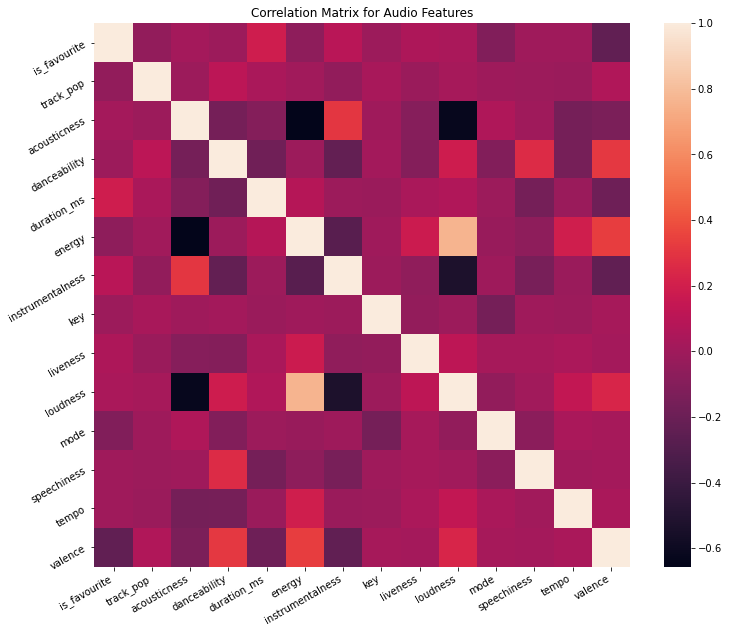

In [0]:
vector_col = 'corr_features'
# Transforming the features into a vector, as pyspark.ml Correlation requires vector input
assembler = VectorAssembler(inputCols=df_features.columns, outputCol=vector_col)
df_vector = assembler.transform(df_features).select(vector_col)
# Collect the results as a NumPy array
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()

# Generating a heatmap using Seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, ax=ax)
ax.set_xticklabels(df_features.columns)
ax.set_yticklabels(df_features.columns)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.title("Correlation Matrix for Audio Features")

We will now plot the distribution of all our features to see if we need to apply any sort of scaler to fit the feature into a normal distribution.

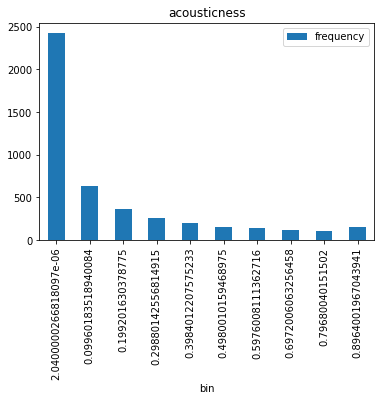

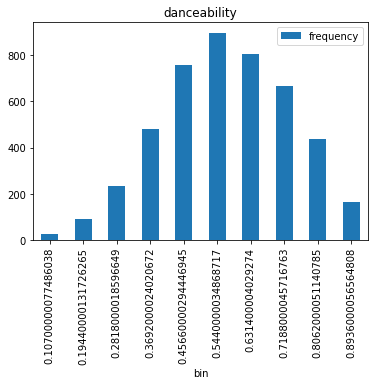

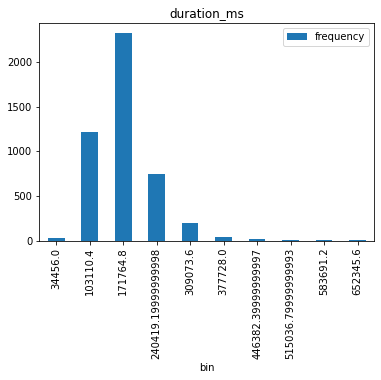

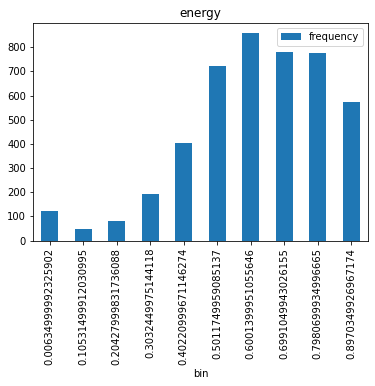

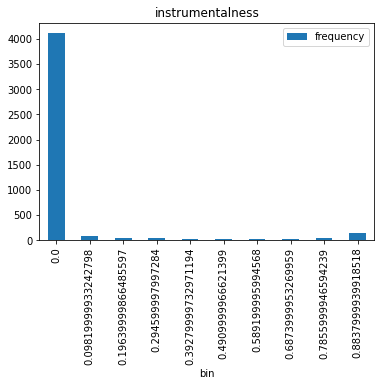

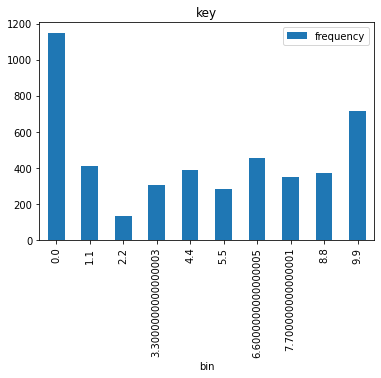

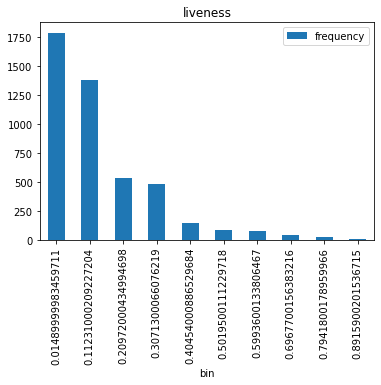

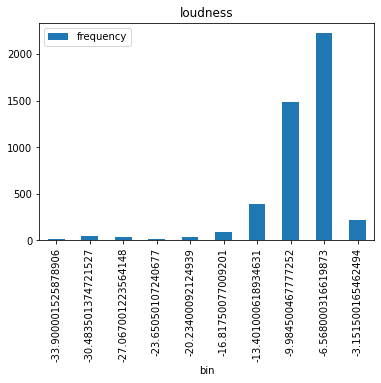

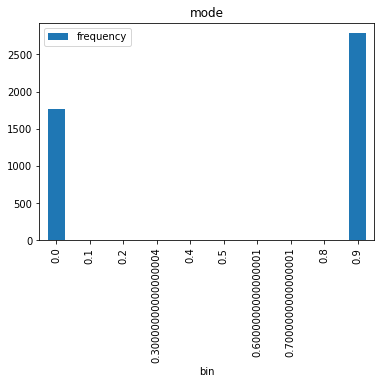

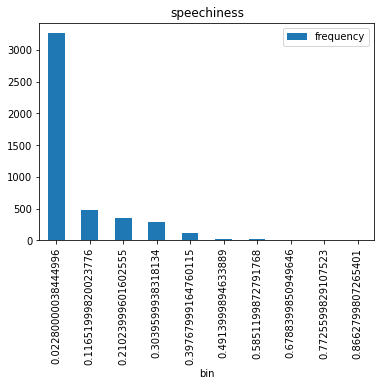

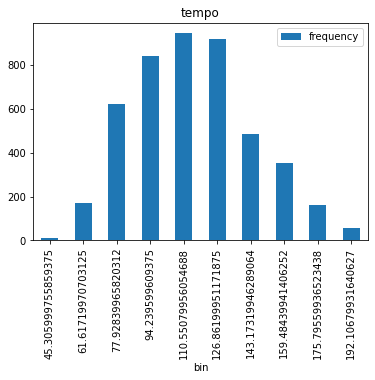

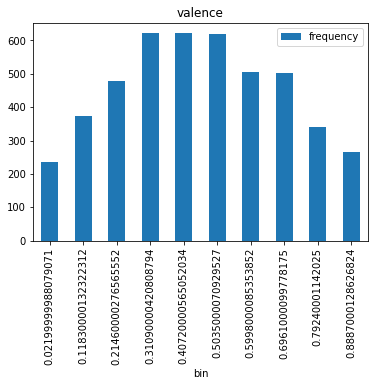

In [0]:
# Getting the column names and types
columns = schema.fieldNames()
schema_dict = schema.jsonValue()['fields']

# Iterate through each audio feature and generate a histogram
for i in range(columns.index('acousticness'), len(columns)):
    feature = columns[i]
    feature_type = schema_dict[i]['type']
    if feature_type == 'float' or feature_type == 'integer':
        histogram = df_features.select(feature).rdd.flatMap(lambda x: x).histogram(10)
        pd_df = pd.DataFrame(
            list(zip(*histogram)),
            columns=['bin', 'frequency']
        ).set_index(
            'bin'
        ).plot(kind='bar')
        plt.title(feature)

It seems that instrumentalness, key, liveness and speechiness do not follow a normal distribution. We will use pyspark.ml StandardScaler on these features (Subsequently, we can also try a variation where we just leave this features as is and see how the model performance is affected). To handle these transformations and subsequently the running of the model elegantly, we will use the pyspark.ml Pipeline instead of running the transformations individually.

We will also split our data into our training and test set here.

In [0]:
df_final = non_duplicate.drop(*[
    'artist_pop', 'artist_genre', 'album_name', 'max(is_favourite)'
])
# Setting 2 different dataframes for the two problems, each with their respective labels
df_regression = df_final.withColumnRenamed('track_pop', 'label')
df_classification = df_final.withColumnRenamed('is_favourite', 'label')

# Here is where we list the features we wish to apply Standard Scaler on
features_to_scale = ['instrumentalness', 'key', 'liveness', 'speechiness']
# Features that will not be put into the ML pipeline
ignore = ['label', 'track_pop', 'is_favourite', 'track_uri', 'track_name', 'artist_name']
remaining_features = list(filter(
    lambda col: col not in features_to_scale and col not in ignore, 
    df_final.columns))
features = remaining_features + ['scaled_' + f for f in features_to_scale]

# Setting up the VectorAssembler & StandardScaler transformations
va1 = [VectorAssembler(inputCols=[f], outputCol=('vec_' + f)) for f in features_to_scale]
ss = [StandardScaler(inputCol='vec_' + f, outputCol='scaled_' + f, withMean=True, withStd=True) for f in features_to_scale]
va2 = VectorAssembler(inputCols=features, outputCol="features")

# Here we split our data into training and test set with 60-40 split, as well as setting seed for reproducibility
regression_train_data, regression_test_data = df_regression.randomSplit([0.6, 0.4], seed=1)
classification_train_data, classification_test_data = df_classification.randomSplit([0.6, 0.4], seed=1)

Here, we will build some functions to run the models and evaluate them.

In [0]:
def run_regression_model(regression: pyspark.ml.regression.Regressor) -> pyspark.ml.Transformer:
    """
    Function that transform data using a pipeline, before training the model and evaluating its performance
    Trained model will be returned
    RMSE, MAE, r2 will be printed out
    If applicable, regression coefficients or feature importances will also be printed
    
    *model: Model to use
    """
    
    # Building the ML pipeline and loading the regression model as the last stage
    stages = va1 + ss + [va2, regression]
    pipeline = Pipeline(stages=stages)
    
    # Train the model on training set and predict on test set
    model = pipeline.fit(regression_train_data)
    predictions = model.transform(regression_test_data)
    
    # Extract name of regression
    name = str(type(regression))
    name = name.split('.')[-1][:-2]
    
    # Evaluate the performance of the regression model
    rmse_evaluator = RegressionEvaluator(labelCol='label', 
                                       predictionCol='prediction', 
                                      metricName='rmse')
    rmse = rmse_evaluator.evaluate(predictions)
    print(f"{name} Root Mean Squared Error: {rmse: .2f}")
    
    mae_evaluator = RegressionEvaluator(labelCol='label', 
                                       predictionCol='prediction', 
                                      metricName='mae')
    mae = mae_evaluator.evaluate(predictions)
    print(f"{name} Mean Absolute Error: {mae: .2f}")
    
    r2_evaluator = RegressionEvaluator(labelCol='label', 
                                       predictionCol='prediction', 
                                      metricName='r2')
    r2 = r2_evaluator.evaluate(predictions)
    print(f"{name} R-Squared: {r2: .2f}")
    
    # Fetch regression coefficients/feature importances
    attrs = sorted(
    (attr['idx'], attr['name']) for attr in (
        chain(*predictions.schema['features'].metadata['ml_attr']['attrs'].values())
    ))
    
    try:
        coefficient_arr = model.stages[-1].coefficients
        coefficients = [
            (name, coefficient_arr[idx]) for idx, name in attrs
            if coefficient_arr[idx]
        ]
        print(f"{name} Coeffecients:")
        print(coefficients)
    except (AttributeError, KeyError) as e:
        pass   
    
    try:
        importances_arr = model.stages[-1].featureImportances
        importances = [
            (name, importances_arr[idx]) for idx, name in attrs
            if importances_arr[idx]
        ]
        print(f"{name} FeatureImportances:")
        print(importances)
    except (AttributeError, KeyError) as e:
        pass
    
    return model

In [0]:
def run_classification_model(classifier: pyspark.ml.classification.Classifier) -> pyspark.sql.DataFrame:
    """
    Function that trains the model and evaluates its performance
    DataFrame of results with predictions will be returned, which are the recommended tracks
    Accuracy will be printed out
    If applicable, precision, recall, confusion matrix or feature importances will also be printed
    
    *classifier: Model to use
    """
    
    # Building the ML pipeline and loading the classification model as the last stage
    stages = va1 + ss + [va2, classifier]
    pipeline = Pipeline(stages=stages)
    
    # Train the model on training set and predict on test set
    model = pipeline.fit(classification_train_data)
    predictions = model.transform(classification_test_data)
    
    # Extract name of classification model
    name = str(type(classifier))
    name = name.split('.')[-1][:-2]
    
    # Evalute accuracy of classification model
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', 
                                                       predictionCol='prediction', 
                                                      metricName='accuracy')
    acc = accuracy_evaluator.evaluate(predictions)
    name = str(type(classifier))
    name = name.split('.')[-1][:-2]
    print(f"{name} Accuracy: {acc: .2f}")
    
    # Fetch feature importances
    attrs = sorted(
    (attr['idx'], attr['name']) for attr in (
        chain(*predictions.schema['features'].metadata['ml_attr']['attrs'].values())
    ))
    try:
        # Fetch precision, recall & confusion matrix
        preds_and_labels = predictions.select(['prediction', 'label']).orderBy('prediction')
        preds_and_labels_fixed = preds_and_labels.withColumn('prediction', preds_and_labels['prediction'].cast(FloatType()))
        preds_and_labels_fixed = preds_and_labels_fixed.withColumn('label', preds_and_labels_fixed['label'].cast(FloatType()))
        metrics = MulticlassMetrics(preds_and_labels_fixed.rdd.map(tuple))
        
        print(f"{name} Precision: {metrics.precision(1.0): .2f}")
        print(f"{name} Recall: {metrics.recall(1.0): .2f}")
        print(f"{name} Confusion Matrix:")
        print(metrics.confusionMatrix().toArray())
        
        # Print feature importances
        importances_arr = model.stages[-1].featureImportances
        importances = [
            (name, importances_arr[idx]) for idx, name in attrs
            if importances_arr[idx]
        ]
        print(f"{name} FeatureImportances:")
        print(importances)
    except (AttributeError, KeyError) as e:
        pass
    
    # Return dataframe of recommended tracks
    new_tracks = predictions.filter(
        (predictions.prediction == 1) & (predictions.label == 0)).select(
        'track_uri', 'track_name', 'artist_name')
    result = new_tracks.dropDuplicates(['track_uri'])
    return result

Here, we set up MLflow to autolog our models and their performance. Note that logging your models will cause training time to be longer, in my case, more so for the GBT models.

In [0]:
# Enable MLFlow autologging
mlflow.set_experiment(experiment_id='317975824579113')
mlflow.pyspark.ml.autolog()

### 4. Regression Models

Now, we can run our models. Firstly, we will run our regression models. Once again, we are looking to predict track popularity through the audio features.

In [0]:
linear_r = LinearRegression(labelCol='label', featuresCol='features')
result_linear_r = run_regression_model(linear_r)

2022/06/23 12:17:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1c6f0702a1a6468689942684117555b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 12:20:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 12:20:12 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
dtr = DecisionTreeRegressor(labelCol='label', featuresCol='features')
result_dtr = run_regression_model(dtr)

2022/06/23 12:25:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e57bee8def74ef7b603f40560e01d71', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 12:28:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 12:28:49 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
rfr = RandomForestRegressor(labelCol='label', featuresCol='features')
result_rfr = run_regression_model(rfr)

2022/06/23 12:34:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb9eef55faa149bb933afcb08729aba0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 12:38:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 12:38:07 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
gbtr = GBTRegressor(labelCol='label', featuresCol='features')
result_gbtr = run_regression_model(gbtr)

2022/06/23 12:43:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '544d2a491f654db09fe158f5e20a29e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 13:17:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 13:17:22 WARNING mlflow.utils.autologging_utils: MLflow autologging e

##### Summary

| | Linear Regression | Decision Tree | RandomForest | GBT |
| :---: | :---: | :---: | :---: | :---: |
| RMSE | 21.63 | 21.09 | 20.44 | 18.80 |
| MAE | 16.33 | 15.84 | 15.43 | 13.84 |
| R2 | 0.03 | 0.07 | 0.13 | 0.26 |

Generally, it seems that the regression models did not perform very well, with very poor r-squared values, suggesting that the models was not able to account for the bulk of the variance in the data.
Linear Regression had the poorest r-squared at 0.03, although the tree based models did better, GBT was only able to hit 0.26. For reference to gauage the RMSE and MAE, the scale of track popularity goes from 0 to 100. Again, GBT has the lowest RMSE and MAE. Overall, GBT is the best performing model.

In terms of feature importances, it seems that for GBT, duration, energy and valence are the most important features.

However, the r-squared is still not very good, so at the moment, this result is not satisfactory. It seems that there are a multitude of other features that determine track popularity besides the track's intrinsic audio features. Some possible ommitted variables are the artist popularity, as well as its genre. Genres would be a bit difficult to use as the possible genres are quite extensive, but perhaps we can explore that in the future.

### 5. Classification Models

Now, we will move on to our classification models. Once again, we are looking to classify tracks as 'is_favourite' or not, through its audio features. For tracks predicted as yes, it means that the track is recommended.

In terms of evaluating the models, we will look at accuracy, precision and recall. In this specific case, it might be better to prioritise precision, as it would mean that we would less irrelevant or poor recommendations, although ideally we want to have a model that can do well in all 3 metrics.

In [0]:
logistic_r = LogisticRegression(labelCol='label', featuresCol='features')
result_logistic_r = run_classification_model(logistic_r)

2022/06/23 13:22:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '606cf31478874ba3877106fe184152c4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 13:27:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 13:27:47 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
dtc = DecisionTreeClassifier(labelCol='label', featuresCol='features')
result_dtc = run_classification_model(dtc)

2022/06/23 13:31:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e93eafc6361f48e69f0f2d7b8b431352', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 13:35:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 13:35:18 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
rfc = RandomForestClassifier(labelCol='label', featuresCol='features')
result_rfc = run_classification_model(rfc)

2022/06/23 13:39:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93e0d2d2d22b471e9a2d2d3a7a48f3ea', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 13:43:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 13:43:20 WARNING mlflow.utils.autologging_utils: MLflow autologging e

In [0]:
gbtc = GBTClassifier(labelCol='label', featuresCol='features')
result_gbtc = run_classification_model(gbtc)

2022/06/23 13:47:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3149856cfe034ea293c992b53f74bb02', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/06/23 14:23:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field vec_instrumentalness. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true."
2022/06/23 14:23:23 WARNING mlflow.utils.autologging_utils: MLflow autologging e

##### Summary

| | Logistic Regression | Decision Tree | RandomForest | GBT |
| :---: | :---: | :---: | :---: | :---: |
| Accuracy | 0.83 | 0.82 | 0.83 | 0.86 |
| Precision | 0.60 | 0.52 | 0.85 | 0.77 |
| Recall | 0.17 | 0.26 | 0.08 | 0.33 |


Generally, all 4 models had good accuracy, all within 0.82 - 0.86. GBT stands out here at 0.86. Comparing precision vs recall, it seems that the models have a tradeoff, whereby there is no model with the best precision and recall. GBT stands out with the highest recall of 0.33, and the second highest precision at 0.77. However, as mentioned earlier, it might be better to prioritise precision, as it would mean that we would less irrelevant or poor recommendations. In that case, we might prefer the RandomForest since it has the highest precision at 0.85, although its recall is poor at 0.08.

In terms of feature importances, it seems that for GBT, tempo, valence and speechiness are the most important features while for RandomForest, duration & valence are the most important features.

Overall, it seems that either RandomForest or GBT could be viable options. For future model development, we can specifically build on these two models and see how we can further tune them to improve performance.

Unfortunately, due to the limitations of the Spotify API and Databricks Community Edition, extracting the recommendations of the models has to be done separately. When run in your own Databricks notebook, the following tables are able to be downloaded into a csv file. From there, use the LoadPlaylists.py file, found in the same repo, to upload them into your Spotify account.

Ideally, with a full Databricks account on one of the cloud providers, we would be able to pick the best performing model and put it into the model registry, before being able to deploy it as a REST API. If that were possible, we would be able to build some sort of scheduled data pipeline to continiously generate recommendations on a rolling basis.

Here we display the recommendations given by the various models.

In [0]:
display(result_logistic_r)

track_uri,track_name,artist_name
spotify:track:0E4Y1XIbs8GrAT1YqVy6dq,Afterglow,Ed Sheeran
spotify:track:0GVcm9IeiuWWOQk3yXI7yx,She Talks to Rainbows,Ramones
spotify:track:0RO9W1xJoUEpq5MEelddFb,Stairway to Heaven - Remaster,Led Zeppelin
spotify:track:0dDGl66J8riMFyp2yUn88W,Say It Again,Will Sparks
spotify:track:0e9JDnz30moH9suCA64omJ,Ego,Jay Critch
spotify:track:0q90594hk25yo0xZmBTqCd,Don't Let the Sun Go Down on Me,George Michael
spotify:track:1DOuZaf52j4O1zlyQpxSQx,Consciousness,Anyma
spotify:track:1W2TYUenzUdOOuATtQIWS2,Particles,Nothing But Thieves
spotify:track:1koJk8rrMBlhDZ8MNiLzH9,Always Remember Us This Way,Lady Gaga
spotify:track:1v7L65Lzy0j0vdpRjJewt1,"Lose Yourself - From ""8 Mile"" Soundtrack",Eminem


In [0]:
display(result_dtc)

track_uri,track_name,artist_name
spotify:track:06eFWpksA3M9qg8GeOGGBX,LET’S DO IT AGAIN - Radio Edit,Jamie xx
spotify:track:0Pie5DFAHHxpkONFUsAI6s,Aneurysm,Nirvana
spotify:track:0QQHnDejdUQbpnOhPgyYmE,Jimmy Neutron,Enumclaw
spotify:track:0VfopEzDeW2ANyBulAFh90,Hard To Trust (feat. Dreezy),King Von
spotify:track:0dDGl66J8riMFyp2yUn88W,Say It Again,Will Sparks
spotify:track:0e9JDnz30moH9suCA64omJ,Ego,Jay Critch
spotify:track:0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,Adele
spotify:track:0l9l90a1zB3wUObtwWbqHy,Glycerine,Bush
spotify:track:0q90594hk25yo0xZmBTqCd,Don't Let the Sun Go Down on Me,George Michael
spotify:track:0r2Bul2NuCViraT2zX1l5j,Get Low,Lil Jon & The East Side Boyz


In [0]:
display(result_rfc)

track_uri,track_name,artist_name
spotify:track:0r2Bul2NuCViraT2zX1l5j,Get Low,Lil Jon & The East Side Boyz
spotify:track:1xJ8RjDucztPOKB0ek95tf,Honest,The Neighbourhood
spotify:track:4Nj2u5IeS8CenFKuSATlm8,Shine A Light,Paolo Nutini
spotify:track:6cKTcheUC3OHDMI8QMKp08,Universal Consciousness,Charlotte de Witte
spotify:track:712uvW1Vezq8WpQi38v2L9,"Bitch, Don’t Kill My Vibe",Kendrick Lamar


In [0]:
display(result_gbtc)

track_uri,track_name,artist_name
spotify:track:0VfopEzDeW2ANyBulAFh90,Hard To Trust (feat. Dreezy),King Von
spotify:track:0e9JDnz30moH9suCA64omJ,Ego,Jay Critch
spotify:track:0l9l90a1zB3wUObtwWbqHy,Glycerine,Bush
spotify:track:0r2Bul2NuCViraT2zX1l5j,Get Low,Lil Jon & The East Side Boyz
spotify:track:1BzXvBpIFWJgu0P8P6xmP4,Stick (with JID & J. Cole feat. Kenny Mason & Sheck Wes),Dreamville
spotify:track:1PEqh7awkpuepLBSq8ZwqD,I Love You Always Forever,Donna Lewis
spotify:track:1koJk8rrMBlhDZ8MNiLzH9,Always Remember Us This Way,Lady Gaga
spotify:track:1xJ8RjDucztPOKB0ek95tf,Honest,The Neighbourhood
spotify:track:2UhhSTIAKDa5lwWItkYvIE,No Way,The Naked And Famous
spotify:track:2kCizKXvF27rJLPVvgIIvm,Miss U,Ego Ella May


### 6. Conclusion

Going back to the 2 questions posed earlier, it seems that we are unable to satisfactorily answer the first question. We might need to reframe the problem entirely. For the second question, it does seem that the classification models are able to achieve good performance, when looking at the evaluation metrics.

Beyond the standard evaluators used for our seleceted models, ultimately, it all depends on whether we actually enjoy the songs recommended. Not recommending based on artists and genres, while it could be a limitation, did lead to a diverse set of recommendations which I personally appreciated. Overall, I had fun exploring these new recommendations.

Nevertheless, it is clear that artists and genres are big componments of how Spotify recommends music and it will be interesting to see how we can incorporate those features into our current model. Furthermore, it is important to note that songs that were part of the source group that were split into the training set will never be recommended. I will leave this as it is for now but there is definitely potential for further development in these areas:
 - Creating a web app/user interface to use this recommendation system (Unfortunately Databricks Community Edition does not allow for publishing of models for deployment)
 - Implement batch processing system to regualrly deliver recommendations
 - More seamless process of extracting results & creating the playlists
 - Incorporate artists & genres into the model
 - Explore other ML models or tune the hyperparameters of current models to achieve better performance, including the use of more typical recommender systems models, such as Collaborative Filtering, Content-based Filtering, etc
 - Come up with solution that does not ignore songs from the source group that ended up in the training set
 
Thank you for reading!
Check out my other work [here](https://github.com/alif898)!